In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import pandas as pd
from pathlib import Path
import rioxarray as rxr
import xarray as xr


In [3]:

ev_folder = Path("data/evs/")
# list the tifs
ev_tifs = list(ev_folder.glob("*.tif"))
ev_tifs

[PosixPath('data/evs/climate_stats.tif'),
 PosixPath('data/evs/wind.tif'),
 PosixPath('data/evs/vegetation-height.tif'),
 PosixPath('data/evs/os-feature-cover-100m.tif'),
 PosixPath('data/evs/os-distance-to-feature.tif'),
 PosixPath('data/evs/terrain-stats.tif'),
 PosixPath('data/evs/bioclim.tif'),
 PosixPath('data/evs/temp_average.tif'),
 PosixPath('data/evs/precipitation.tif'),
 PosixPath('data/evs/ceh-land-cover-100m.tif'),
 PosixPath('data/evs/dtm-100m.tif')]

In [4]:

# read the tifs into a list of xarray objects
evs = [rxr.open_rasterio(ev_tif, band_as_variable=True) for ev_tif in ev_tifs]
# Name each EV using the filename
for ev, ev_tif in zip(evs, ev_tifs):
    ev.attrs["file_name"] = ev_tif.stem

In [5]:
def assign_band_names(ds):
    if "long_name" not in ds["band_1"].attrs:
        return ds
    band_names = {var: ds[var].attrs["long_name"] for var in ds.data_vars}
    renamed_ds = ds.rename(band_names)
    return renamed_ds

evs = [assign_band_names(ev) for ev in evs]

In [6]:
# Prefix band names with the file_name for each dataset
evs = [ev.rename({var: f"{ev.attrs['file_name']}_{var}" for var in ev.data_vars}) for ev in evs]

In [7]:
ev_stack = xr.merge(evs)
ev_stack

<xarray.Dataset>
Dimensions:                                         (x: 792, y: 563)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/107)
    climate_stats_temp_ann_var                      (y, x) float64 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_temp_mat_avg                      (y, x) float64 ...
    climate_stats_prec_ann_var                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    climate_stats_wind_ann_var                      (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Littoral rock               (y, x) float64 ...
    ceh-land-cover-100m_Littoral sediment           (y, x) float64 ...
    ceh-land-cover-100m_Saltmarsh                   (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    ceh-land-cover-100m_Suburban                    (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
    file_name:      climate_stats

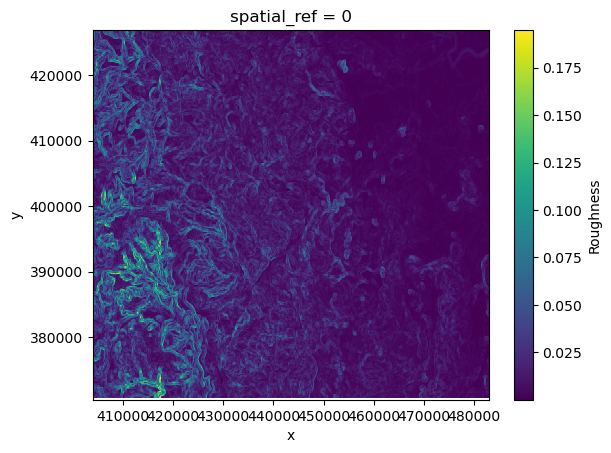

In [8]:
ev_stack["terrain-stats_Roughness"].plot()

# Run some Checks

In [9]:
ev_df = ev_stack.to_dataframe()
ev_df.head()

spatial_ref  climate_stats_temp_ann_var  \
x             y                                                        
403914.879459 426796.145539            0                         NaN   
              426696.051974            0                         NaN   
              426595.958408            0                         NaN   
              426495.864843            0                         NaN   
              426395.771277            0                         NaN   

                             climate_stats_temp_ann_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_temp_mat_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_prec_ann_var  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_prec_ann_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_wind_ann_var  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_wind_ann_avg  wind_wind_1  \
x             y                                                        
403914.879459 426796.145539                         NaN          NaN   
              426696.051974                         NaN          NaN   
              426595.958408                         NaN          NaN   
              426495.864843                         NaN          NaN   
              426395.771277                         NaN          NaN   

                             wind_wind_2  ...  ceh-land-cover-100m_Saltwater  \
x             y                           ...                                  
403914.879459 426796.145539          NaN  ...                            NaN   
              426696.051974          NaN  ...                            NaN   
              426595.958408          NaN  ...                            NaN   
              426495.864843          NaN  ...                            NaN   
              426395.771277          NaN  ...                            NaN   

                             ceh-land-cover-100m_Freshwater  \
x             y                                               
403914.879459 426796.145539                             NaN   
              426696.051974                             NaN   
              426595.958408                             NaN   
              426495.864843                             NaN   
          

In [10]:
ev_df.drop(columns=["spatial_ref"], inplace=True)

## Missing Values

There should be some missing values where I've clipped the data using a buffer but it should be less than 30%.

In [11]:
# Count the missing values per variable and sor tin descending order
ev_df.isna().mean().sort_values(ascending=False)

os-distance-to-feature_distance_to_woodland       0.274181
os-distance-to-feature_distance_to_major_roads    0.274181
os-distance-to-feature_distance_to_minor_roads    0.274181
os-distance-to-feature_distance_to_water          0.274181
os-distance-to-feature_distance_to_buildings      0.274181
                                                    ...   
terrain-stats_twi                                 0.003552
terrain-stats_slope                               0.003552
terrain-stats_aspect_eastness                     0.003552
terrain-stats_aspect_northness                    0.003552
terrain-stats_curvature                           0.003552
Length: 107, dtype: float64

Where are the missing values in the dataset?

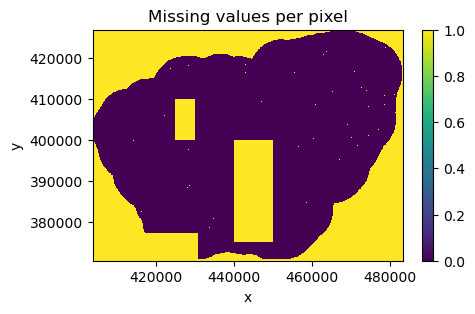

In [12]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
np.isnan(ev_stack.to_array()).any(axis=0).plot(ax = ax)
# add title
ax.set_title("Missing values per pixel")

plt.show()


In [13]:
ev_df.dropna(inplace=True)

ev_correlations = ev_df.corr()
ev_correlations.head()

,climate_stats_temp_ann_var,climate_stats_temp_ann_avg,climate_stats_temp_mat_avg,climate_stats_prec_ann_var,climate_stats_prec_ann_avg,climate_stats_wind_ann_var,climate_stats_wind_ann_avg,wind_wind_1,wind_wind_2,wind_wind_3,...,ceh-land-cover-100m_Saltwater,ceh-land-cover-100m_Freshwater,ceh-land-cover-100m_Supralittoral rock,ceh-land-cover-100m_Supralittoral sediment,ceh-land-cover-100m_Littoral rock,ceh-land-cover-100m_Littoral sediment,ceh-land-cover-100m_Saltmarsh,ceh-land-cover-100m_Urban,ceh-land-cover-100m_Suburban,dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation
climate_stats_temp_ann_var,1.000000,0.862312,0.893252,-0.882059,-0.875518,-0.843802,-0.735242,-0.778561,-0.774925,-0.748636,...,0.003851,0.029605,NaN,NaN,NaN,NaN,0.001720,0.157936,0.110755,-0.857834
climate_stats_temp_ann_avg,0.862312,1.000000,0.995857,-0.938624,-0.962217,-0.961968,-0.869904,-0.905142,-0.908993,-0.891671,...,0.016931,0.030078,NaN,NaN,NaN,NaN,0.009619,0.156925,0.165304,-0.979464
climate_stats_temp_mat_avg,0.893252,0.995857,1.000000,-0.936239,-0.957801,-0.957342,-0.865557,-0.901205,-0.904105,-0.886229,...,0.014326,0.034137,NaN,NaN,NaN,NaN,0.008159,0.168350,0.170221,-0.973660
climate_stats_prec_ann_var,-0.882059,-0.938624,-0.936239,1.000000,0.993773,0.945947,0.815002,0.863807,0.863153,0.836653,...,-0.020890,-0.026377,NaN,NaN,NaN,NaN,-0.011958,-0.086850,-0.057148,0.968027
climate_stats_prec_ann_avg,-0.875518,-0.962217,-0.957801,0.993773,1.000000,0.952303,0.818403,0.867168,0.868321,0.842322,...,-0.022537,-0.028760,NaN,NaN,NaN,NaN,-0.012950,-0.091470,-0.072438,0.983102


Some of the correlations ar NA because the values are all 0 in the dataset. This is where that land cover feature doesn't exist inland and should just be converted to NA.

In [14]:
ev_correlations.fillna(0, inplace=True)

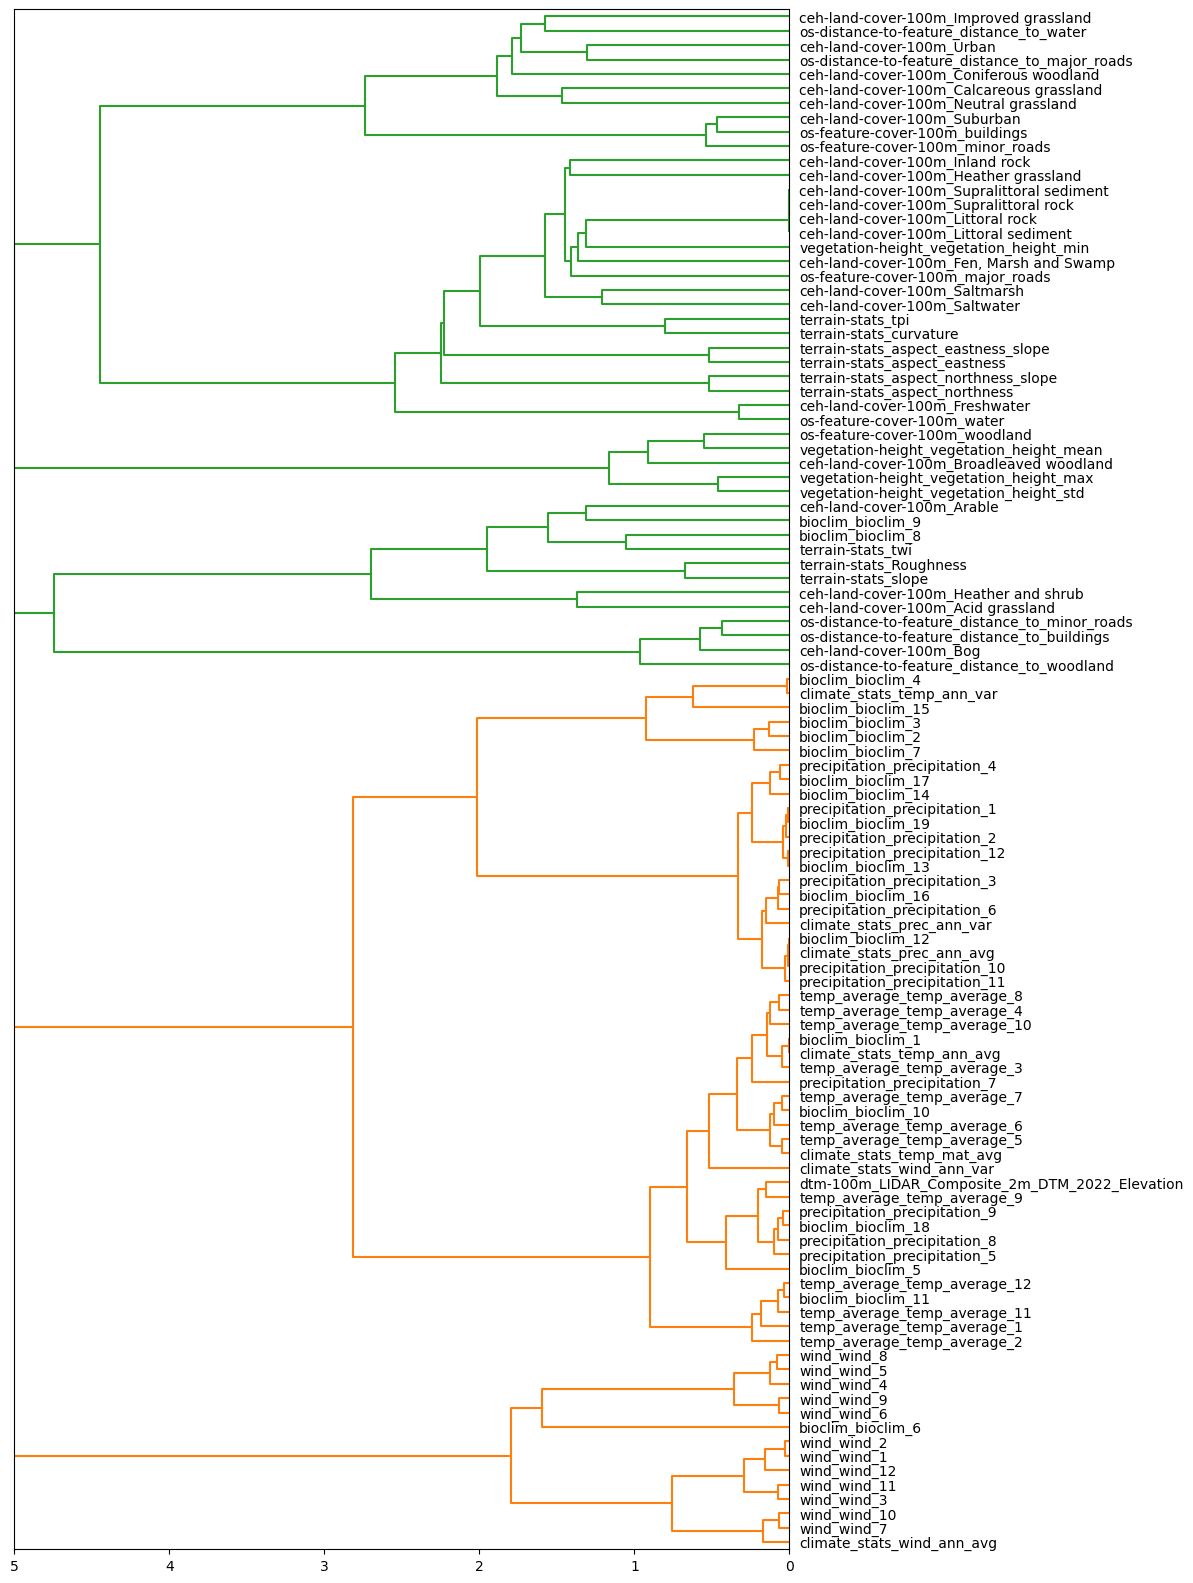

In [23]:
from scipy.cluster import hierarchy

# Calculate distance between each variable (1 - correlation to have a sense of distance)
distance = 1 - ev_correlations.abs()

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(distance, method='ward')

plt.figure(figsize=(10,20))
hierarchy.dendrogram(linkage_matrix, labels=ev_correlations.columns.tolist(), orientation="left", leaf_font_size=10)
plt.xlim(5, 0)
plt.show()

In [16]:
# Cluster the samples
cluster_ids = hierarchy.fcluster(linkage_matrix, t=1.2, criterion='distance')

# Create a DataFrame to see clusters
column_clusters = pd.DataFrame({'cluster_id': cluster_ids, 'column_name': ev_df.columns})
print(column_clusters.cluster_id.value_counts().sort_index())

1      8
2      5
3      1
4     25
5     16
6      6
7      4
8      1
9      1
10     2
11     2
12     1
13     1
14     5
15     2
16     2
17     2
18     2
19     1
20     1
21     4
22     1
23     1
24     1
25     1
26     1
27     3
28     1
29     1
30     1
31     1
32     1
33     1
34     1
Name: cluster_id, dtype: int64


In [21]:
column_clusters = column_clusters.sort_values("cluster_id")
column_clusters.to_csv("data/evs/ev_clusters.csv", index=False)